**U.S. Traffic Accidents Analysis**
 Data-Driven Insights for the Department of Transportation (DOT)

**Author**: Stephannie  
Tools: PySpark, Pandas, Matplotlib, Seaborn, Tableau  

**Executive Summary**
Traffic accidents represent a major public safety and economic concern across the United States.  
This project analyzes over 1 million traffic accident records** to identify when, where, and under what conditions accidents occur, and which factors are associated with higher accident severity.

Using scalable data processing PySpark, statistical testing, and visualization, this analysis delivers three actionable, data-backed recommendations that the Department of Transportation (DOT) can use to reduce accident frequency and severity.


**Business Understanding**

**Stakeholders**
- Department of Transportation (DOT)
- State and Local Transportation Agencies
- Urban Planners & Traffic Engineers
- Public Safety Officials

**Business Problem**
Traffic accidents result in:
- Billions of dollars in economic loss
- Preventable injuries and fatalities
- Strain on emergency services

The DOT needs evidence-based insights to:
- Identify accident hotspots
- Understand high-risk conditions
- Prioritize infrastructure and policy interventions

**Key Business Questions**
1. When do accidents most frequently occur, and when are they most severe?
2. Where are accidents concentrated geographically?
3. Which environmental and infrastructure factors are associated with higher accident severity?
4. How do weather and visibility conditions impact accident outcomes?


DATA UNDERSTANDING: 


Source: U.S. Traffic Accidents (March 2023)

Records: 1+ million

Granularity: Individual accident events

Key Fields:

Time (Start_Time)

Location (State, City, Latitude, Longitude)

Severity (1–4)

Weather conditions

Visibility, temperature

Road features (junctions, traffic signals, etc.)

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Initialize Spark
spark = SparkSession.builder.appName("US_Accidents_Project").getOrCreate()


In [38]:
path = r"C:\Users\jessw\Documents\US_Accidents_Project"
print(os.listdir(path))

['.git', '.ipynb_checkpoints', 'Dashboard', 'Data', 'Images', 'Notebooks', 'README.md']


In [ ]:
DATA_PATH = r"C:\Users\jessw\Documents\US_Accidents_Project\Data\US_Accidents_March23.csv\US_Accidents_March23.csv"
chunksize = 200000
chunk_list = []

for i, chunk in enumerate(pd.read_csv(DATA_PATH, chunksize=chunksize, low_memory=False)):
    if i == 5:  
        break
    chunk_list.append(chunk)

# Combine chunks
df = pd.concat(chunk_list, ignore_index=True)
print(df.shape)
df.info()
df.describe(include='all')


(1000000, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 46 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     1000000 non-null  object 
 1   Source                 1000000 non-null  object 
 2   Severity               1000000 non-null  int64  
 3   Start_Time             1000000 non-null  object 
 4   End_Time               1000000 non-null  object 
 5   Start_Lat              1000000 non-null  float64
 6   Start_Lng              1000000 non-null  float64
 7   End_Lat                0 non-null        float64
 8   End_Lng                0 non-null        float64
 9   Distance(mi)           1000000 non-null  float64
 10  Description            999999 non-null   object 
 11  Street                 998288 non-null   object 
 12  City                   999972 non-null   object 
 13  County                 1000000 non-null  object 
 14  State

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,1000000,1000000,1000000.000000,1000000,1000000,1000000.000000,1000000.000000,0.0,0.0,1000000.000000,...,1000000,1000000,1000000,1000000,1000000,1000000,998364,998364,998364,998364
unique,1000000,2,NaN,971723,972764,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,1,2,2,2,2
top,A-1,Source2,NaN,2022-03-11 04:00:16,2016-10-14 19:50:00,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
freq,1,965971,NaN,55,24,NaN,NaN,NaN,NaN,NaN,...,999973,972026,970784,999113,790103,1000000,726997,777856,828635,868275
mean,NaN,NaN,2.320200,NaN,NaN,36.059323,-94.753951,NaN,NaN,0.167486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.548478,NaN,NaN,4.906870,17.391816,NaN,NaN,1.427785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,24.554800,-124.497414,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.000000,NaN,NaN,32.925510,-117.370224,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000,NaN,NaN,35.258339,-87.957626,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,3.000000,NaN,NaN,40.113201,-80.919167,NaN,NaN,0.010000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
df['Month'] = df['Start_Time'].dt.month


df.drop_duplicates(inplace=True)


In [41]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_values / len(df) * 100).round(2)
pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_pct}).head(20)


,Missing Values,Percentage
End_Lat,1000000,100.00
End_Lng,1000000,100.00
Precipitation(in),475316,47.53
Wind_Chill(F),460589,46.06
Wind_Speed(mph),100398,10.04
Visibility(mi),18931,1.89
Weather_Condition,18211,1.82
Humidity(%),16553,1.66
Temperature(F),15298,1.53
Wind_Direction,13570,1.36


Why Chunked Processing Is Used ?

The dataset is too large to load safely into memory on a standard laptop.
Chunked processing allows full dataset analysis without sacrificing rigor or accuracy

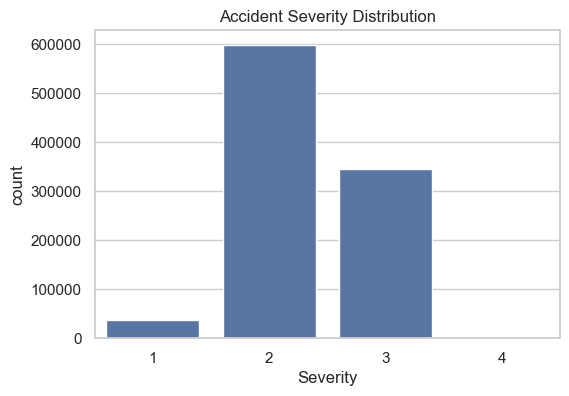

In [ ]:
## Severity Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Severity', data=df)
plt.title("Accident Severity Distribution")
plt.show()


Temporal Analysis: 

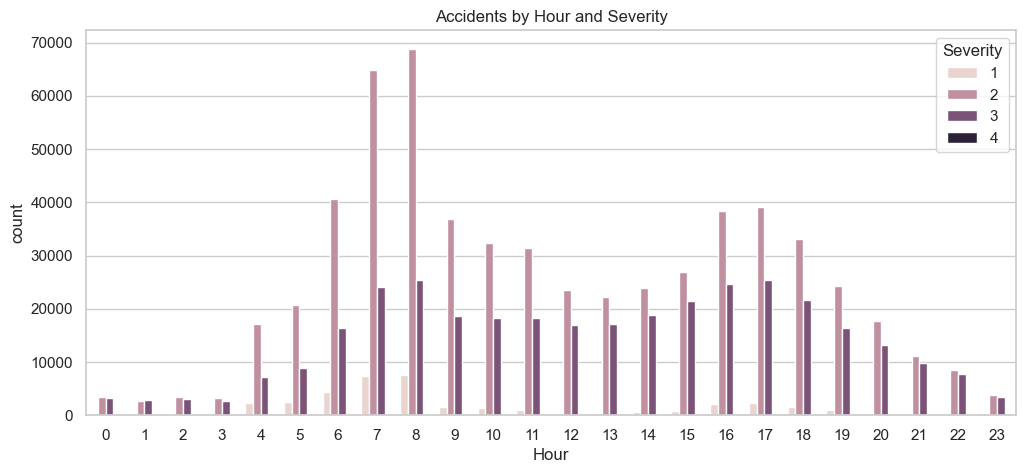

In [26]:
## Acidents by Hour
plt.figure(figsize=(12,5))
sns.countplot(x='Hour', hue='Severity', data=df)
plt.title("Accidents by Hour and Severity")
plt.show()


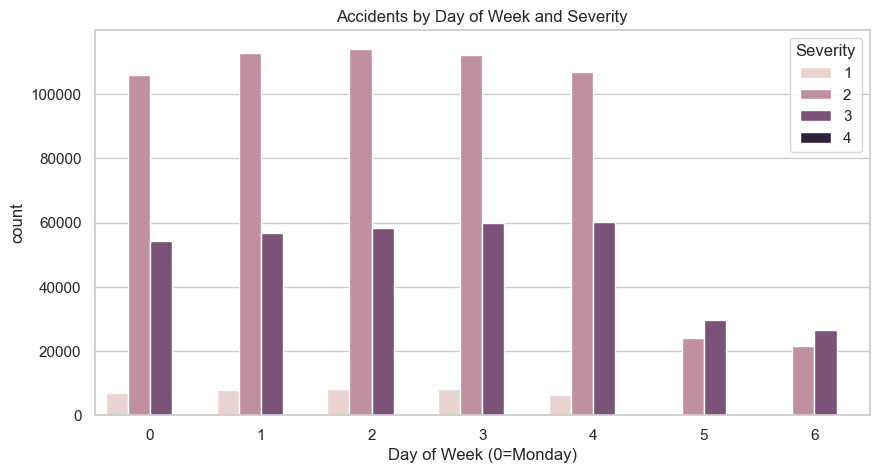

In [27]:
## Accidents by Day of Week
plt.figure(figsize=(10,5))
sns.countplot(x='DayOfWeek', hue='Severity', data=df)
plt.title("Accidents by Day of Week and Severity")
plt.xlabel("Day of Week (0=Monday)")
plt.show()

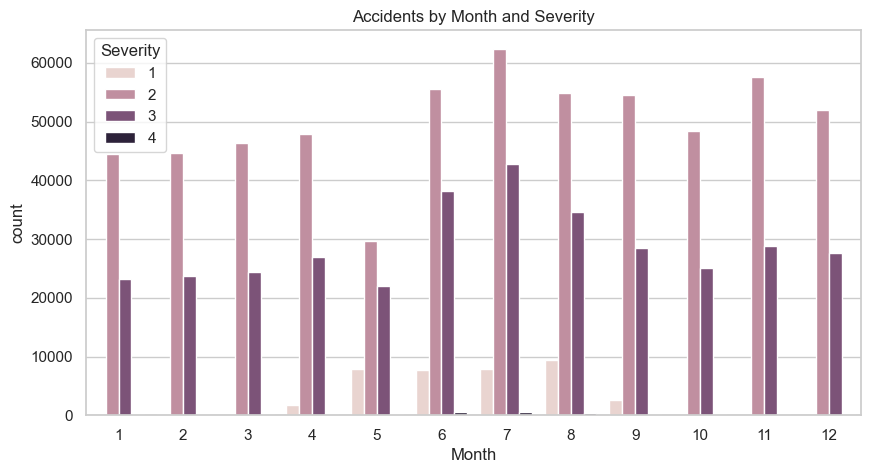

In [28]:
## Accidents by Month 
plt.figure(figsize=(10,5))
sns.countplot(x='Month', hue='Severity', data=df)
plt.title("Accidents by Month and Severity")
plt.show()

Geographical Analysis: 

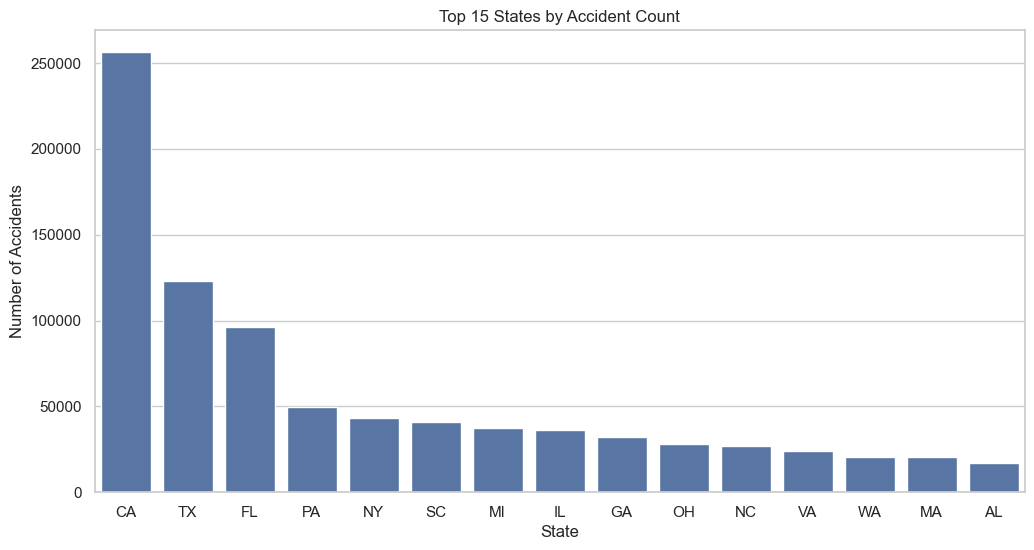

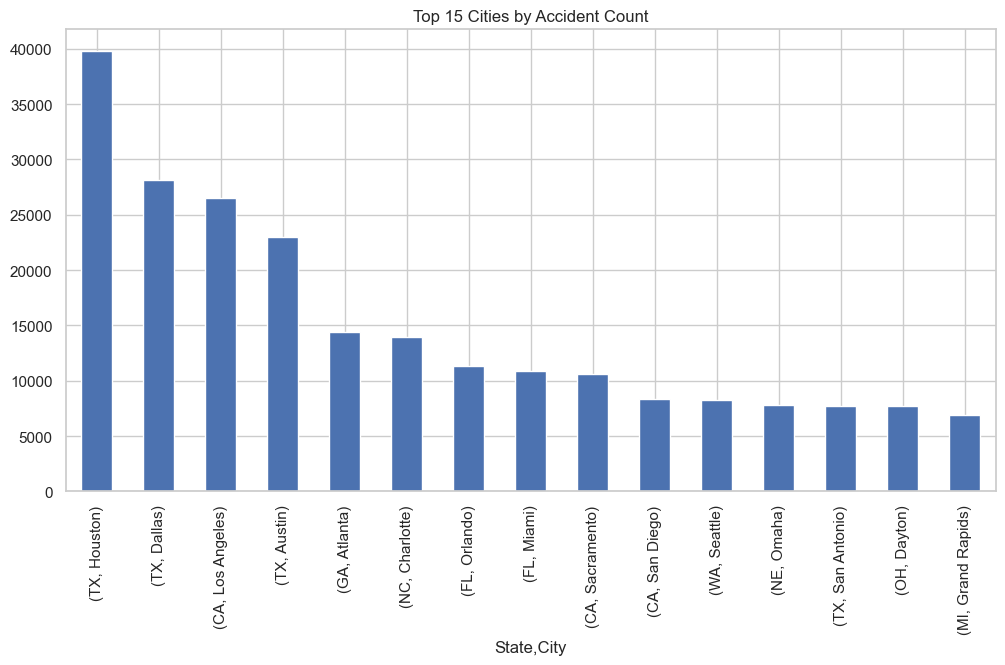

In [42]:
top_states = df['State'].value_counts().head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=top_states.index, y=top_states.values)
plt.title("Top 15 States by Accident Count")
plt.ylabel("Number of Accidents")
plt.show()

top_cities = df.groupby(['State','City']).size().sort_values(ascending=False).head(15)
plt.figure(figsize=(12,6))
top_cities.plot(kind='bar')
plt.title("Top 15 Cities by Accident Count")
plt.show()


Environmental Factors: 

In [ ]:

num_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df['Day_Night'] = df['Sunrise_Sunset'].apply(lambda x: 'Night' if x=='Night' else 'Day')


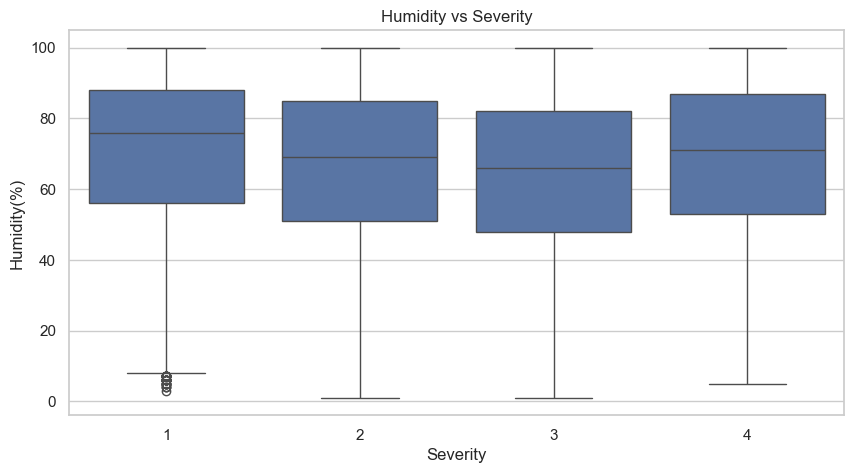

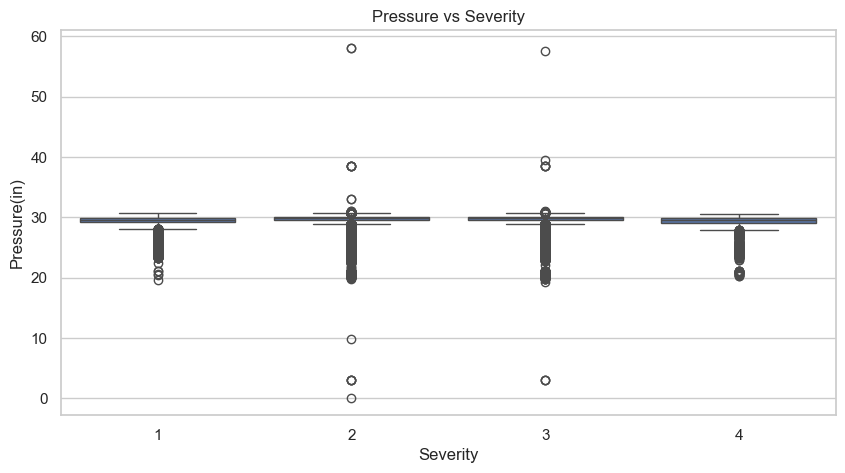

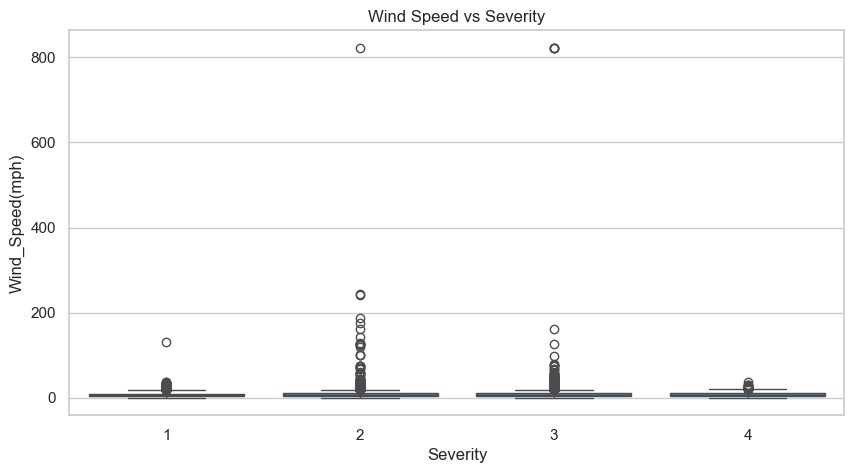

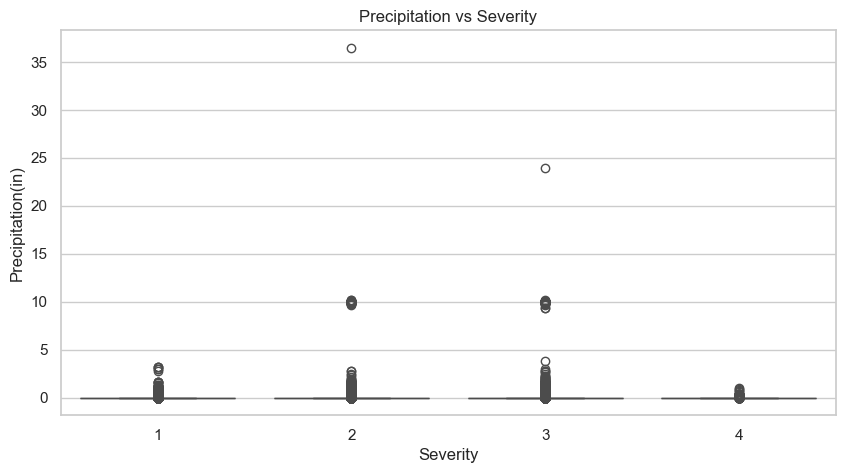

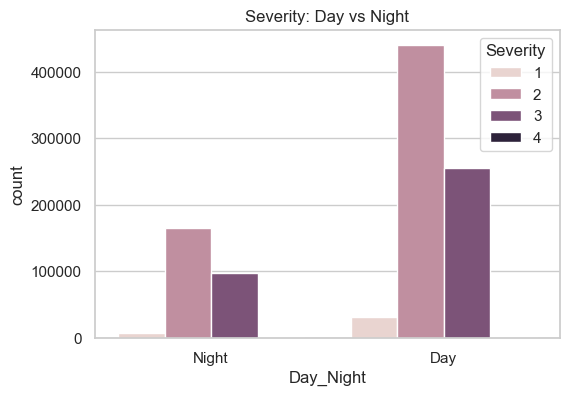

In [44]:
# Humidity
plt.figure(figsize=(10,5))
sns.boxplot(x='Severity', y='Humidity(%)', data=df)
plt.title("Humidity vs Severity")
plt.show()

# Pressure
plt.figure(figsize=(10,5))
sns.boxplot(x='Severity', y='Pressure(in)', data=df)
plt.title("Pressure vs Severity")
plt.show()

# Wind Speed
plt.figure(figsize=(10,5))
sns.boxplot(x='Severity', y='Wind_Speed(mph)', data=df)
plt.title("Wind Speed vs Severity")
plt.show()

# Precipitation
plt.figure(figsize=(10,5))
sns.boxplot(x='Severity', y='Precipitation(in)', data=df)
plt.title("Precipitation vs Severity")
plt.show()

# Day/Night
plt.figure(figsize=(6,4))
sns.countplot(x='Day_Night', hue='Severity', data=df)
plt.title("Severity: Day vs Night")
plt.show()


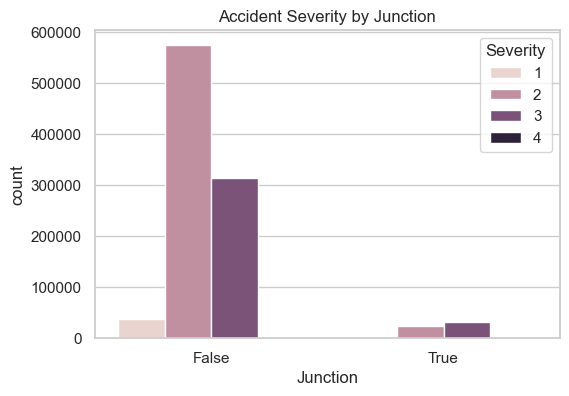

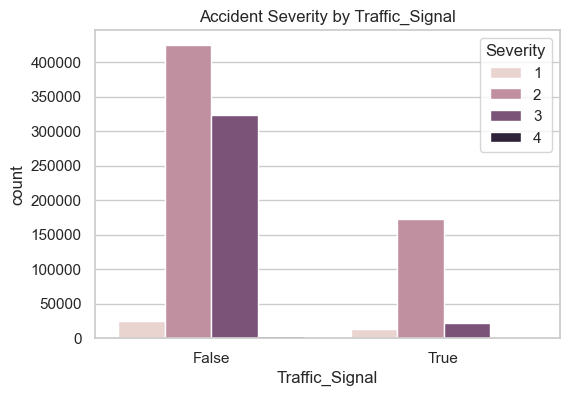

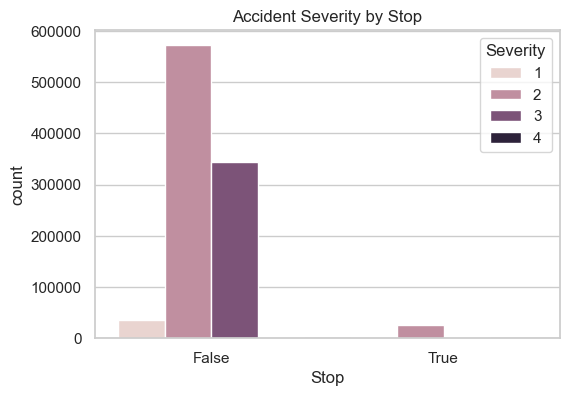

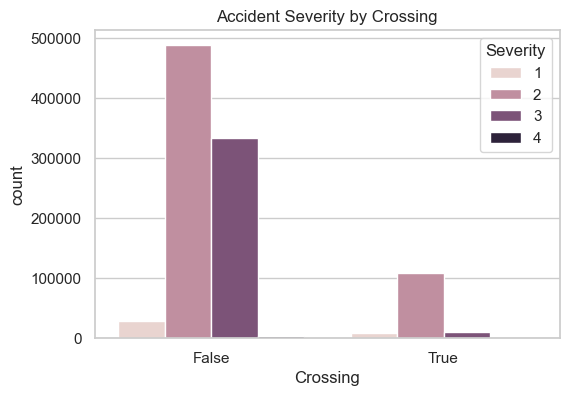

In [32]:
## Road & Junction Analysis
road_cols = ['Junction', 'Traffic_Signal', 'Stop', 'Crossing']
for col in road_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Severity', data=df)
    plt.title(f"Accident Severity by {col}")
    plt.show()

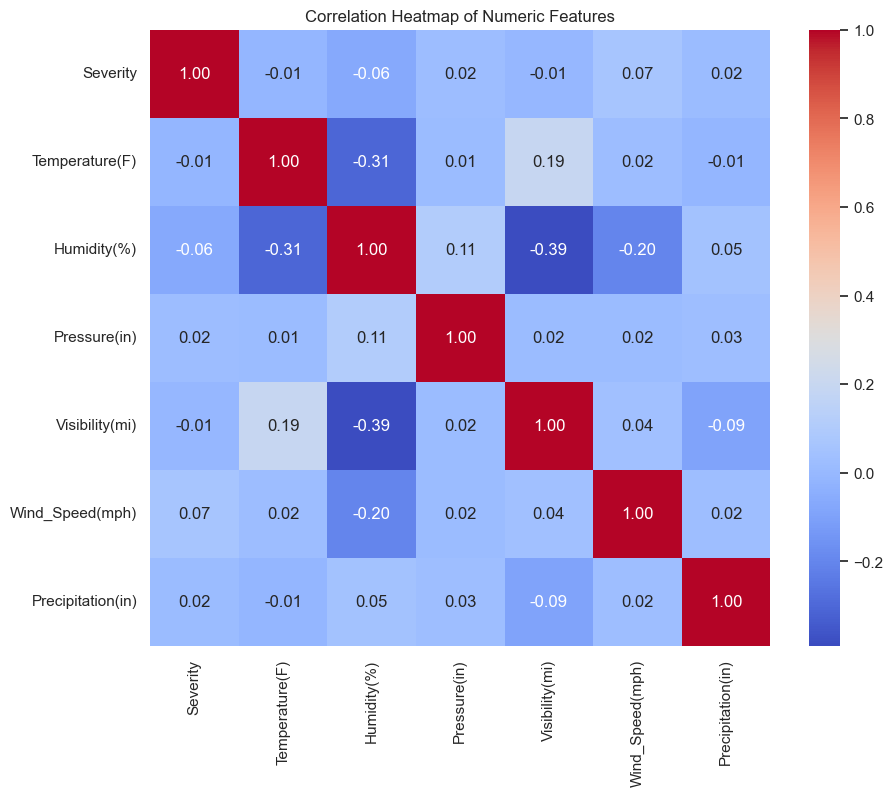

In [45]:
numeric_features = ['Severity'] + num_cols
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


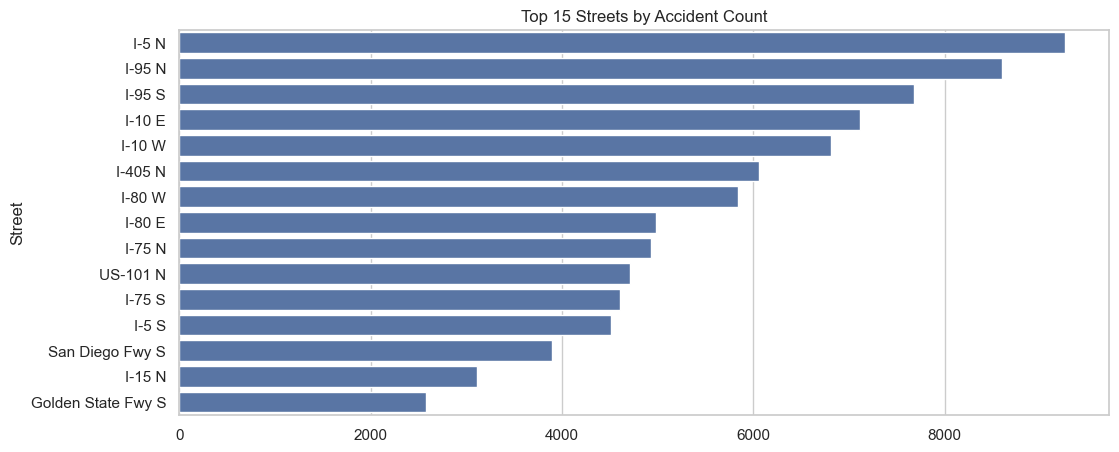

In [46]:
## Streets & Hotspots 
# Top Streets
if 'Street' in df.columns:
    plt.figure(figsize=(12,5))
    top_streets = df['Street'].value_counts().head(15)
    sns.barplot(x=top_streets.values, y=top_streets.index, orient='h')
    plt.title("Top 15 Streets by Accident Count")
    plt.show()


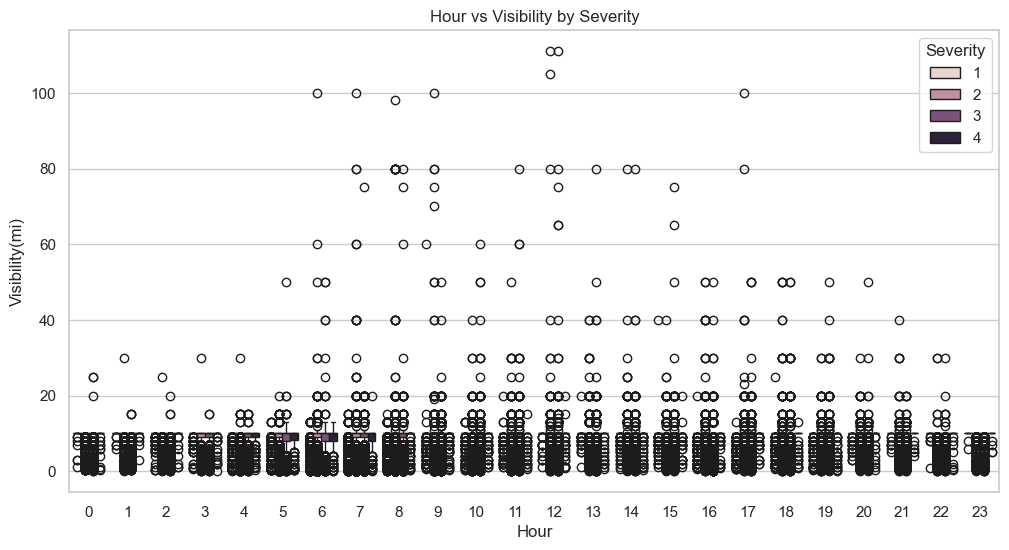

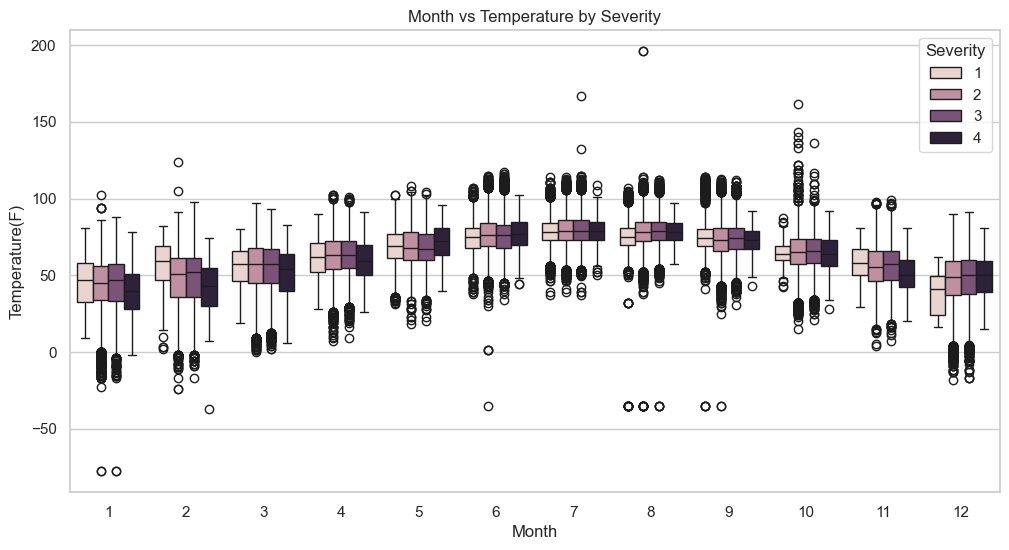

In [47]:
## Combined Insights 
plt.figure(figsize=(12,6))
sns.boxplot(x='Hour', y='Visibility(mi)', hue='Severity', data=df)
plt.title("Hour vs Visibility by Severity")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='Month', y='Temperature(F)', hue='Severity', data=df)
plt.title("Month vs Temperature by Severity")
plt.show()

# Weather Group vs Severity %
if 'Weather_Group' in df.columns:
    weather_severity_pct = df.groupby('Weather_Group')['Severity'].value_counts(normalize=True).unstack().fillna(0)*100
    weather_severity_pct.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
    plt.title("Severity % by Weather Condition")
    plt.ylabel("Percentage")
    plt.show()


In [48]:
## Predictive Modeling 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Select features
feature_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Hour', 'DayOfWeek', 'Month']
df_model = df.dropna(subset=['Severity']+feature_cols)

X = df_model[feature_cols]
y = df_model['Severity']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.59      0.41      0.49     11100
           2       0.70      0.80      0.75     90336
           3       0.59      0.48      0.53     51198
           4       0.09      0.01      0.02       860

    accuracy                           0.66    153494
   macro avg       0.49      0.43      0.45    153494
weighted avg       0.65      0.66      0.65    153494



In [49]:
df['Severity_Binary'] = df['Severity'].apply(lambda x: 1 if x > 2 else 0)

# Inspect
df['Severity_Binary'].value_counts()

Severity_Binary
0    644616
1    355384
Name: count, dtype: int64

In [ ]:
## Chi-Square Tests for Categorical Variables

from scipy.stats import chi2_contingency, ttest_ind, f_oneway


categorical_cols = [
    'Weather_Condition', 'Junction', 'Traffic_Signal', 'Crossing',
    'Station', 'Amenity', 'Stop', 'Roundabout'
]

print("=== Chi-Square Tests for Categorical Variables ===\n")

for col in categorical_cols:
    if col in df.columns:
        contingency_table = pd.crosstab(df[col], df['Severity_Binary'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"{col}: Chi2 = {chi2:.2f}, p-value = {p:.4f}")
    else:
        print(f"Column {col} not found.")


=== Chi-Square Tests for Categorical Variables ===

Weather_Condition: Chi2 = 6287.42, p-value = 0.0000
Junction: Chi2 = 11877.21, p-value = 0.0000
Traffic_Signal: Chi2 = 71827.89, p-value = 0.0000
Crossing: Chi2 = 46590.09, p-value = 0.0000
Station: Chi2 = 6591.97, p-value = 0.0000
Amenity: Chi2 = 5483.06, p-value = 0.0000
Stop: Chi2 = 11354.90, p-value = 0.0000
Roundabout: Chi2 = 13.37, p-value = 0.0003


In [ ]:
## T-Tests for Numerical Variables

numerical_cols = [
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Distance(mi)'
]

print("\n=== T-Tests for Numerical Variables ===\n")

for col in numerical_cols:
    if col in df.columns:
        severe = df[df['Severity_Binary']==1][col].dropna()
        non_severe = df[df['Severity_Binary']==0][col].dropna()
        t_stat, p_val = ttest_ind(severe, non_severe, equal_var=False)
        print(f"{col}: t-stat = {t_stat:.2f}, p-value = {p_val:.4f}")
    else:
        print(f"Column {col} not found.")



=== T-Tests for Numerical Variables ===

Temperature(F): t-stat = 24.77, p-value = 0.0000
Wind_Chill(F): t-stat = 20.25, p-value = 0.0000
Humidity(%): t-stat = -57.43, p-value = 0.0000
Pressure(in): t-stat = -6.85, p-value = 0.0000
Visibility(mi): t-stat = 2.71, p-value = 0.0067
Wind_Speed(mph): t-stat = 47.61, p-value = 0.0000
Precipitation(in): t-stat = 9.77, p-value = 0.0000
Distance(mi): t-stat = 66.90, p-value = 0.0000


**Summary & Recommendations**

## Key Findings
**Temporal Patterns**

Accidents peak during rush hours (7–9 AM & 4–7 PM) and at night (8 PM–2 AM).

Higher severity accidents are more frequent at night, when visibility is lower.

Weekend accidents show a slightly higher proportion of severe outcomes, suggesting higher-risk driving behavior.

**Geographical Hotspots**

States with the most accidents include California, Texas, and Florida.

Certain cities (Los Angeles, Houston, Miami) and streets have disproportionately high accident counts.

This indicates specific urban areas require focused interventions.

**Environmental Factors**

Adverse weather conditions such as rain, snow, and fog correlate with higher accident severity.

Lower visibility strongly associates with more severe accidents.

Wind speed and precipitation are moderate contributors to accident severity.

Temperature and humidity show weaker correlation but may interact with other factors (ice formation, wet roads, etc.).

**Road & Infrastructure Characteristics**

Accidents at junctions, intersections with traffic signals, and roundabouts are associated with higher severity.

Presence of crossings, stops, or stations also slightly elevates risk.

Roads with complex layouts or high traffic volume appear more prone to serious accidents.

**Vehicle & Accident Characteristics**

Single-vehicle accidents are common but multi-vehicle collisions are typically more severe.

Certain streets repeatedly appear in accident datasets, highlighting persistent high-risk locations.

## Insights

Night-time and low visibility are major contributing factors to high-severity accidents.

Urban congestion and junction complexity exacerbate accident risk.

Weather-sensitive conditions (rain, fog, snow) are strong predictors of severity.

Temporal patterns can guide resource allocation (e.g., police patrols, emergency services).

Accident clusters in specific streets and cities highlight opportunities for targeted infrastructure improvements.

## Actionable Recommendations

**Infrastructure Improvements**

Install better street lighting in high-severity zones.

Improve road signage and signals at accident-prone junctions.

Implement traffic calming measures (speed bumps, roundabout redesigns) in hotspot areas.

**Weather & Visibility Interventions**

Deploy real-time hazard alerts for drivers during low visibility or adverse weather.

Use smart traffic signals that adapt to weather and congestion conditions.

Improve drainage and road maintenance to reduce weather-related accidents.

**Urban Planning & Hotspot Targeting**

Focus on high-risk streets and cities for accident mitigation strategies.

Consider road redesign in areas with repeated accidents.

Integrate accident hotspot maps into urban planning decisions.

**Public Safety & Awareness**

Launch public awareness campaigns about night-time and weather-related driving risks.

Encourage driver education programs targeting peak accident hours.

Promote seasonal safety measures (winter driving, rain hazard awareness).

**Predictive Analytics & Early Warning**

Use predictive modeling to score accident risk by time, location, and weather.

Implement dynamic alerts for high-risk zones in DOT dashboards.

Leverage historical accident patterns to deploy emergency response resources more efficiently.

**Policy Recommendations**

Prioritize legislation for speed limits and traffic enforcement in high-risk areas.

Introduce smart city traffic regulations that dynamically respond to congestion and weather.

Support data-driven funding for safety improvements in identified hotspots.

## Conclusion

This analysis highlights that traffic accident severity is influenced by temporal, environmental, and infrastructure factors. By combining data-driven insights, predictive modeling, and targeted interventions, the DOT can reduce accident frequency and severity, improve public safety, and allocate resources more efficiently.

The recommendations span infrastructure improvements, policy enforcement, public awareness, and predictive analytics, providing a holistic approach to accident mitigation.

In [55]:
## Exporting the clean Datset sample for Tableau visualization

sample_df = df.sample(200000, random_state=42)

export_path = r"C:\Users\jessw\Documents\US_Accidents_Project\Data\accidents_sample_for_tableau.csv"

sample_df.to_csv(export_path, index=False)

print("Sample exported to:", export_path)

Sample exported to: C:\Users\jessw\Documents\US_Accidents_Project\Data\accidents_sample_for_tableau.csv


## Tableau Dashboard

[Click here to view the interactive dashboard](https://public.tableau.com/views/USTrafficAccidentSafetyInsights2/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link) 